In [1]:
## Some of the code seems to require Python 3

import sys
sys.version

'3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) \n[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]'

In [ ]:
from scipy.stats import gaussian_kde

## Plot density
def plot_density(x,y,s = 10):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig = plt.figure(0,)
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, )

    ax.scatter(x, y, c=z, s=s, edgecolor='')

In [2]:
from qnet.algebra.operator_algebra import *
from qnet.algebra.circuit_algebra import *
import qnet.algebra.state_algebra as sa
from qnet.circuit_components.displace_cc import Displace

from qnet.algebra.operator_algebra import get_coeffs ### used later to make time-dependent terms from reduced model.

from qutip import *
from scipy import *

import sympy; sympy.init_printing(use_latex="mathjax")
from sympy import sqrt
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import itertools
from imp import reload
import pickle

## Sometimes Macs will have an issue with Matplotlib, this seems to fix it.
## see http://stackoverflow.com/questions/21784641/installation-issue-with-matplotlib-python

import matplotlib as mil
mil.use('TkAgg')

/Users/gil/anaconda/envs/python_3_env/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
## save to a folder

import os
directory_name = "/trajectory_data"
d = (os.getcwd() + directory_name)
try:
    os.stat(d)
except:
    os.mkdir(d)

In [57]:
####
Regime = "kerr_bistable_cascade"

# Define Kerr parameters
chi = symbols("chi", real=True, positive=True)
Delta = symbols("Delta", real=True)
kappa_1, kappa_2 = symbols("kappa_1, kappa_2", real=True, positive=True)
alpha0 = symbols("alpha_0")

## bistable regime
if Regime == "kerr_bistable_cascade":
    params = {alpha0 : 49., chi : -106.066, Delta : 750., kappa_1 : 220, kappa_2 : 1e-10,
              'Ntraj' : 1, 'duration' : 100000., 'Nfock' : 15}
else:
    ## qubit regime
    params = {alpha0 : 10.0, chi : -100, Delta : 1e-10, kappa_1 : 0.5, kappa_2 : 1e-10,
              'Ntraj' : 10, 'duration' : 25000., 'Nfock' : 15}

## These are used later in the simulation
Ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']


In [58]:
## matlab file.
save_mat = False
## pkl file (can be loaded in python) in the same format as above.
save_pkl = True
file_name = "." + directory_name + '/' + Regime

In [59]:
NUM_KERR = 2

In [60]:
# Construct Kerr SLH
a_lst = [Destroy(str(i)) for i in range(NUM_KERR)]

for a in a_lst:
    a.space.dimension = Nfock

S_lst = [-identity_matrix(2)]*NUM_KERR
L_lst = [[sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k] for a_k in a_lst]
H_lst = [Delta*a_k.dag()*a_k + chi/2*a_k.dag()*a_k.dag()*a_k*a_k for a_k in a_lst]
KERR_lst = [SLH(S, L, H).toSLH() for S,L,H in zip(S_lst,L_lst,H_lst) ]

In [61]:
## single Kerr SLH
single_kerr_slh = KERR_lst[0] << Displace(alpha=alpha0)+cid(1)
single_kerr_slh = single_kerr_slh.toSLH()

In [62]:
## multiple Kerr SLH
slh = single_kerr_slh
for i in range(1,NUM_KERR):
    slh = KERR_lst[i]<< slh
slh = slh.toSLH()

## $H$ and $L$ of single Kerr.

In [63]:
single_kerr_slh

SLH(Matrix([[-1, 0], [0, -1]]), Matrix([[OperatorPlus(ScalarTimesOperator(-alpha_0, IdentityOperator), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('0', ''))))], [ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('0', '')))]]), OperatorPlus(ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(alpha_0*sqrt(kappa_1), Create(LocalSpace('0', ''))), ScalarTimesOperator(-sqrt(kappa_1)*conjugate(alpha_0), Destroy(LocalSpace('0', ''))))), ScalarTimesOperator(chi/2, OperatorTimes(Create(LocalSpace('0', '')), Create(LocalSpace('0', '')), Destroy(LocalSpace('0', '')), Destroy(LocalSpace('0', '')))), ScalarTimesOperator(Delta, OperatorTimes(Create(LocalSpace('0', '')), Destroy(LocalSpace('0', ''))))))

In [64]:
single_kerr_slh_num = single_kerr_slh.substitute(params)

In [65]:
# slh_num.space.dimension = Nfock**2
single_kerr_psi0 = qutip.basis(Nfock, 0)
Tsim = np.arange(0, duration/1000, 1e-3)

single_kerr_H_num, single_kerr_L_num = single_kerr_slh_num.HL_to_qutip()

In [66]:
single_kerr_slh_num

SLH(Matrix([[-1, 0], [0, -1]]), Matrix([[OperatorPlus(ScalarTimesOperator(-49.0000000000000, IdentityOperator), ScalarTimesOperator(2*sqrt(55), Destroy(LocalSpace('0', ''))))], [ScalarTimesOperator(1.00000000000000e-5, Destroy(LocalSpace('0', '')))]]), OperatorPlus(ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(98.0*sqrt(55), Create(LocalSpace('0', ''))), ScalarTimesOperator(-98.0*sqrt(55), Destroy(LocalSpace('0', ''))))), ScalarTimesOperator(-53.0330000000000, OperatorTimes(Create(LocalSpace('0', '')), Create(LocalSpace('0', '')), Destroy(LocalSpace('0', '')), Destroy(LocalSpace('0', '')))), ScalarTimesOperator(750.000000000000, OperatorTimes(Create(LocalSpace('0', '')), Destroy(LocalSpace('0', ''))))))

In [67]:
## Observables for single kerr

a = a_lst[0]
single_kerr_obs = tuple([a.dag()*a, a+a.dag(), (a-a.dag())/1j])
single_kerr_obsq = [o.to_qutip(full_space=single_kerr_slh.space) for o in single_kerr_obs]

## $H$ and $L$ of multiple Kerr.

In [68]:
slh

SLH(Matrix([[1, 0], [0, 1]]), Matrix([[OperatorPlus(ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('1', ''))), ScalarTimesOperator(-1, OperatorPlus(ScalarTimesOperator(-alpha_0, IdentityOperator), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('0', ''))))))], [OperatorPlus(ScalarTimesOperator(-sqrt(kappa_2), Destroy(LocalSpace('0', ''))), ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('1', ''))))]]), OperatorPlus(ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(-1, OperatorPlus(ScalarTimesOperator(-kappa_2, OperatorTimes(Destroy(LocalSpace('0', '')), Create(LocalSpace('1', '')))), ScalarTimesOperator(-sqrt(kappa_1), OperatorTimes(OperatorPlus(ScalarTimesOperator(-alpha_0, IdentityOperator), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('0', '')))), Create(LocalSpace('1', '')))))), ScalarTimesOperator(-kappa_2, OperatorTimes(Create(LocalSpace('0', '')), Destroy(LocalSpace('1', '')))), ScalarTimesOperator(-sqrt(kappa_1), OperatorTimes(OperatorPlus(Sc

In [69]:
slh_num = slh.substitute(params)

# slh_num.space.dimension = Nfock**2
psi0 = qutip.tensor([qutip.basis(Nfock,0)]*NUM_KERR)
Tsim = np.arange(0, duration/1000, 1e-3)

H_num, L_num = slh_num.HL_to_qutip()

## Observables

obs = tuple(itertools.chain.from_iterable([[a.dag()*a, a+a.dag(), (a-a.dag())/1j ]  
           for a in a_lst]))
    
obsq = [o.to_qutip(full_space=slh.space) for o in obs]

In [70]:
# ## generate trajectory
# single_kerr_mcdata = qutip.mcsolve(single_kerr_H_num, single_kerr_psi0, Tsim, single_kerr_L_num, 
#                        single_kerr_obsq, ntraj=Ntraj, 
#                        options=qutip.Odeoptions(store_states=True,average_expect=False))

In [71]:
## generate trajectory
mcdata = qutip.mcsolve(H_num, psi0, Tsim, L_num, 
                       obsq, ntraj=Ntraj, 
                       options=qutip.Odeoptions(store_states=True,average_expect=False))

100.0%. Run time: 599.35s. Est. time left: 00:00:00:00
Total run time: 599.54s


In [ ]:
## generate trajectory
mcdata_rho = qutip.mesolve(H_num, psi0, Tsim, L_num, 
                       obsq,
                       options=qutip.Odeoptions(store_states=True,average_expect=False))

# Original Stochastic Trajectories

## System 1

In [ ]:
# plt.plot(np.average(np.asarray(mcdata.expect), axis = 0).T[:,:3] );
# plt.plot(np.asarray(mcdata_rho.expect).T[:,:3], c = 'k');

## System 2

In [ ]:
# plt.plot(np.average(np.asarray(mcdata.expect), axis = 0).T[:,3:6] );
# # plt.plot(np.asarray(mcdata_rho.expect).T[:,3:], c = 'k');

In [ ]:
## 3 or more KERRs
# plt.plot(np.average(np.asarray(mcdata.expect), axis = 0).T[:,6:] );
# # plt.plot(np.asarray(mcdata_rho.expect).T[:,3:], c = 'k');

(0, 14)

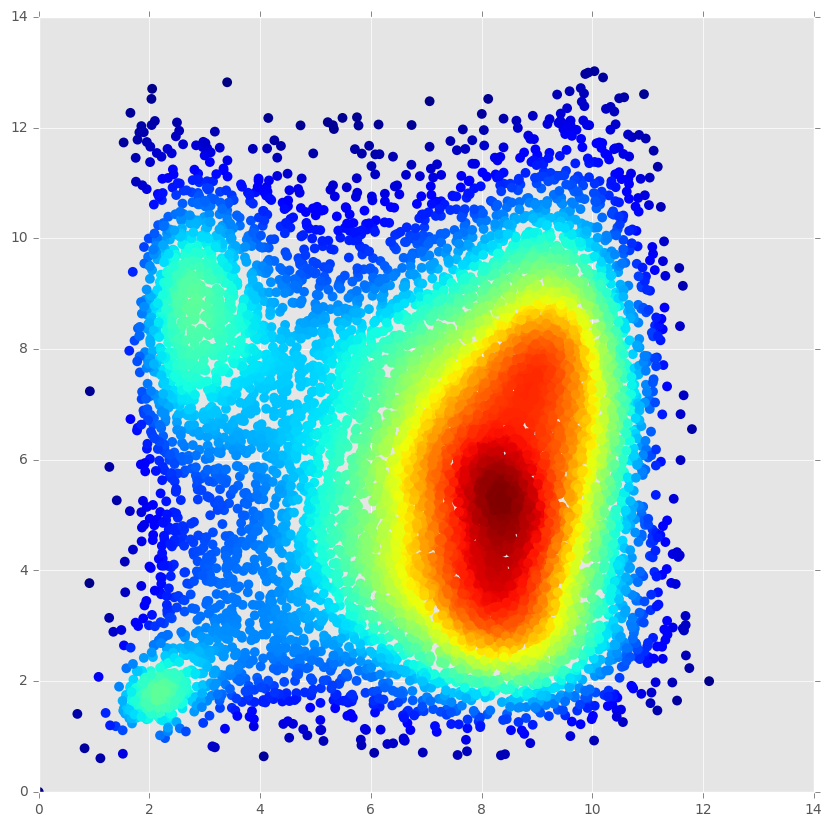

In [72]:
N1full,x1full, p1full, N2full, x2full, p2full = np.concatenate(np.asarray(mcdata.expect),axis = -1)[:,::10]

plot_density(N1full, N2full,s = 50)
plt.xlim(0,14)
plt.ylim(0,14)

In [73]:
## save as matlab or pkl file

from mcdata2matfile_or_pkl import mcdata2matfile_or_pkl

if save_mat:
    mcdata2matfile_or_pkl(mcdata, file_name, obs, save_mat = True, save_pkl = False)    
if save_pkl:
    mcdata2matfile_or_pkl(mcdata, file_name, obs, save_mat = False, save_pkl = True, params=params)

/Users/gil/Documents/repos/diffusion_maps/make_quantum_jump_trajectories/trajectory_data/kerr_bistable_cascade.pkl

## Von Neumann Entropy

### Estimate from trajectories

In [199]:
mean_and_std = lambda z: [np.mean(z, axis = 0), np.std(z, axis = 0)]

In [200]:
time_samples = range(len(Tsim))[::int(duration / 120)]

In [201]:
### mean and standard deviation of the Von Neumann entorpy of each subsystem for stochastic trajectories.
### Since the join states are pure, we can trace either of them out and get the same result.
### See https://en.wikipedia.org/wiki/Entropy_of_entanglement

VN_entropy_stoch_0 = np.asarray( [ mean_and_std([qutip.entropy.entropy_vn(mcdata.states[jj][t].ptrace(0))
                    for jj in range(min(50,params['Ntraj']))])
                          for t in time_samples])

In [202]:
### Von Neumann entropy of each of the subsystems in the full solver
### See https://en.wikipedia.org/wiki/Joint_quantum_entropy

VN_entropy_rho_0 = np.asarray([qutip.entropy.entropy_vn(mcdata_rho.states[t].ptrace(0))
                          for t in time_samples])
VN_entropy_rho_1 = np.asarray([qutip.entropy.entropy_vn(mcdata_rho.states[t].ptrace(1))
                          for t in time_samples])
VN_entropy_rho_01 = np.asarray([qutip.entropy.entropy_vn(mcdata_rho.states[t])
                          for t in time_samples])

In [203]:
upper = VN_entropy_stoch[:,0] + VN_entropy_stoch[:,1] 
lower = VN_entropy_stoch[:,0] - VN_entropy_stoch[:,1] 

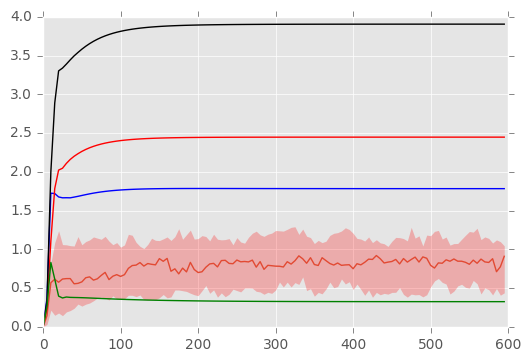

In [205]:
plt.plot(time_samples,VN_entropy_stoch_0[:,0])
plt.plot(time_samples,VN_entropy_rho_0, c='b')
plt.plot(time_samples,VN_entropy_rho_1, c='r')
plt.plot(time_samples,VN_entropy_rho_01, c='k')
plt.plot(time_samples,VN_entropy_rho_0 + VN_entropy_rho_1 - VN_entropy_rho_01, c='g')
plt.fill_between(time_samples, upper, lower, color='#ff0000', alpha=.25, linewidth=0)
plt.show()